In [40]:
LEGI = 19917558

# SLT-CE-4: Constant Shift Embedding

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

 <h2 style="background-color:#f0b375;"> Setup </h2>

We start by importing necessary python packages.

In [41]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

import scipy.linalg as la
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

# Fix randoom seed for reproducibility
np.random.seed(42)
from scipy.optimize import linear_sum_assignment
import numpy.lib.index_tricks as ndi
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score, normalized_mutual_info_score

from sklearn.manifold import TSNE
import warnings
import pandas as pd
import seaborn as sns

from scipy.spatial.distance import squareform, pdist
import scipy.sparse as sps
import scipy.sparse.csgraph as spsg

The number of nodes is hardcoded for simplicity (taken from [2]):

In [42]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [43]:
# initialize data matrix which will be an adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0], pair[1]] = 1
        DATA[pair[1], pair[0]] = 1

Note that DATA specifies an adjacency matrix of the email graph. It's not claimed to be a proper dissimilarity matrix required by CSE algorithm. So, you are allowed to perform any manipulations to construct a suitable (dis-)similarity matrix for the further analysis.

Next we define a class which contains main functionalities.

In [44]:
class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self, metric = "cosine"):
        self.PMAT = None
        self.S_c = None 
        self.D_tilde = None 
        self.metric = metric 

    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """
        # Save data
        n = PMAT.shape[0]
        for i in range(n):
            PMAT[i,i] = 1
        self.PMAT = PMAT
        
        # Create D and symmetrize it
        if self.metric == "shortestpath":
            D = spsg.shortest_path(sps.csr_matrix(PMAT.copy()), directed=True, unweighted=True)
            D[D == np.inf] = np.max(D[D != np.inf])+1
        else:
            D = squareform(pdist(PMAT, metric=self.metric))
        D_sym = 0.5*(D + D.T)
        
        # Centralization
        Q = np.eye(n) - (1/n)*np.ones((n,n))
        self.S_c = -(1/2)*Q.dot(D_sym).dot(Q) 

        # Minimal shift
        self.D_tilde = D_sym - 2*np.linalg.eigvalsh(self.S_c)[0]*(np.ones((n,n)) - np.eye(n))
        
        
    def get_embedded_vectors(self, p):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        n = self.PMAT.shape[0]   
        Q = np.eye(n) - (1/n)*np.ones((n,n))

        S_c_tilde = -0.5*Q.dot(self.D_tilde).dot(Q)
        
        #PCA
        eig_values, eig_vectors = np.linalg.eigh(S_c_tilde)
        Xp = eig_vectors[:, ::-1][:, :p] @ np.diag(np.sqrt(np.flip(eig_values)[:p]))
        
        S_tilde_reconstruct = np.matmul(Xp, Xp.T)
        D_tilde_reconstruct = S_tilde_reconstruct.diagonal()[:, np.newaxis] + S_tilde_reconstruct.diagonal()[np.newaxis, :] - 2 * S_tilde_reconstruct
        return Xp, D_tilde_reconstruct

In [45]:
def permute_dissimilarity_matrix(clusters):
    permutes = np.concatenate([np.where(clusters == i)[0] for i in np.unique(clusters)])
    idsizes = np.array([np.sum(clusters == i) for i in np.unique(clusters)])
    return permutes, idsizes

def matchinglabels(y_true, y_pred):
    cmatrix = skl.metrics.cluster.contingency_matrix(y_pred, y_true)
    labels_map = np.argmax(cmatrix, axis=1)
    return labels_map[y_pred]


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

 **Constant Shift Embedding**: following the slides of Lecture 7 and [1] we have that

 We first compute (Section 3 of [1])
1. *Symmetric matrix:* $D_\text{sym} = \frac{1}{2} (D + D^T)$,
2. *Centralization:* $S^c = -\frac{1}{2} D^c$, with $D^c = QD_\text{sym}Q$ and $Q = I_n - \frac{1}{n}e_n e_n^T$ (Lemma 1 of [1])
3. *Minimal Shift:* $\tilde D = D_\text{sym} - 2 \lambda_n(S^c)(e_n e_n^T - I_n)$ (Theorem 2 of [1]).

Given a general dissimilarity matrix $D$, in above 3 steps, we obtain a shifted matrix $\tilde{D}$ which derives from squared Euclidean distances between points $\left\{x_i\right\}_{i=1}^n$ in some vector space. This property of $\tilde{D}$ implies that the corresponding matrix $\tilde{S}^c$ is positive semidefinite and, thus, a dot product matrix $\tilde{S}^c=X X^{\top}$. According to Lemma 1 of [1] $, \tilde{S}^c$ can be calculated as $\tilde{S}^c=-\frac{1}{2} \tilde{D}^c$. 

We can recover the vectors $\left\{x_i\right\}_{i=1}^n$  by an eigenvalue decomposition of $\tilde{S}^c$ as follows (kernel PCA of reference [14] in [1]).
1. $\tilde S^c = -\frac{1}{2} Q \tilde D Q$,
2. $\tilde S^c = V \Lambda V^T$ as the eigenvalue decomposition,
3. Calculate the $n \times p$ map matrix $X_p=V_p\left(\Lambda_p\right)^{1 / 2}$, with $V_p=\left(v_1, \ldots v_p\right)$ and $\Lambda_p=\operatorname{diag}\left(\lambda_1, \ldots \lambda_p\right)$.
The rows of $X_p$ contain the vectors $\left\{x_i\right\}_{i=1}^n$ in $p$ dimensional space, whose mutual distances are given by $\tilde{D}$.


<p style="background-color:#adebad;">
    Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.
</p>    

In [46]:
CSE = ConstantShiftEmbedding()

<p style="background-color:#adebad;">
    Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].
</p>    

In [47]:
CSE.fit(DATA)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.
</p>

In [48]:
eig_spectrum = np.flip(np.linalg.eigvalsh(CSE.S_c))

In [49]:
## Determine a good cut-off value (and write some lines to explain your choice)
p_opt = 50
print("Chosen cut-off value is: ", p_opt)

Chosen cut-off value is:  50


The optimal $p$ value chose is 50 (with cosine distance as metric, see section 6 for giustification of choice) since after this value, the magnitute of the next eigenvalues start decreasing at a much slower rate (informally, we are using the so called elbow method for clustering).

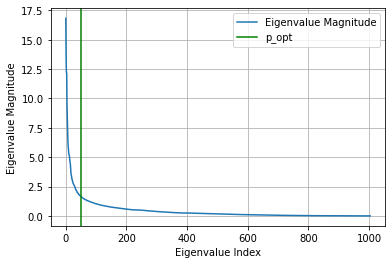

In [50]:
## Plot spectrum and indicate the cut-off value on the spectrum
plt.plot(eig_spectrum, label='Eigenvalue Magnitude')
plt.axvline(x=p_opt, color='g', linestyle='-', label='p_opt')
plt.grid(True)
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue Magnitude')
plt.legend()
plt.show()

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Plot the distance matrices both for the denoised ($p = p^*$ -- from the previous step) and the original versions as shown in figure 5 in [1]. Note that the distance matrix is a matrix with pairwise distances between every two points from the dataset ($d_{ij} = dist(x_i, x_j)$).<br>
    Perform K-MEANS algorithm for varying number of clusters K on the embedded vectors derrived from CSE. You may use the sklearn implementation of K-MEANS. To make the aforementioned plots meaningful, sort the nodes according to the cluster belongings for every number of clusters K (see the figure 5). For now, there is no need to include the actual ground truth labels given in [2].
</p>

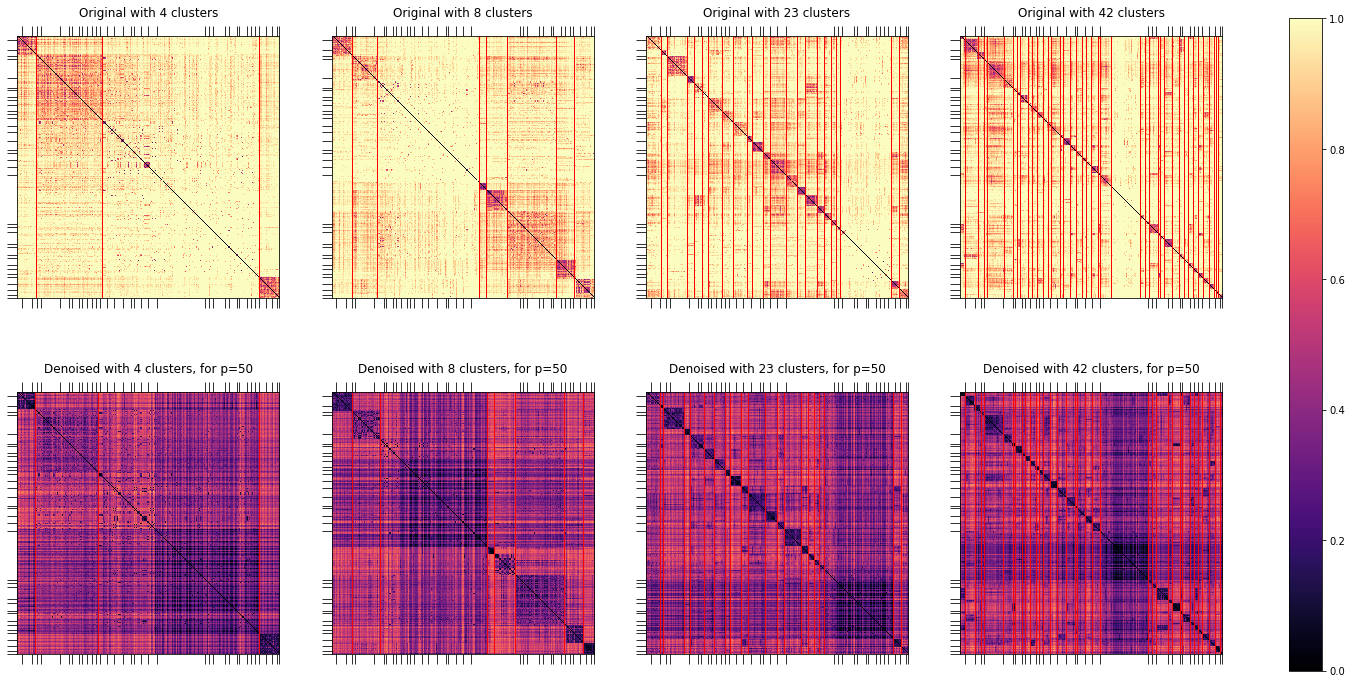

In [51]:
embedded_vectors_denoised, D_denoised= CSE.get_embedded_vectors(p_opt)
vectors_original, D_original = CSE.get_embedded_vectors(DATA.shape[0])

num_clusters = [4, 8, 23, 42]
fig, axes = plt.subplots(2, len(num_clusters), figsize=(24, 12), sharex=True, sharey=True)
for i, k in enumerate(num_clusters):
    clusters_denoised = KMeans(n_clusters=k, random_state=42, n_init=50).fit_predict(embedded_vectors_denoised)
    clusters_original = KMeans(n_clusters=k, random_state=42, n_init=50).fit_predict(vectors_original)
    
    matched_clusters = matchinglabels(clusters_original, clusters_denoised)

    permutes_popt, indexsize_denoised = permute_dissimilarity_matrix(matched_clusters)
    permutes_orig, indexsize_original = permute_dissimilarity_matrix(clusters_original)
    
    permuted_evd = D_denoised[permutes_popt][:, permutes_popt]  
    permuted_vo = D_original[permutes_orig][:, permutes_orig]  

    vmin = np.min(permuted_vo)
    vmax = np.max(permuted_vo)
    
    cumsum_original_indexes = np.cumsum(indexsize_original) - 0.5
    cumsum_denoised_indexes = np.cumsum(indexsize_denoised) - 0.5
    
    axes[0, i].matshow(permuted_vo, cmap="magma", vmin=vmin, vmax=vmax)
    axes[0, i].tick_params(axis='both', which='major', length=10)
    axes[0, i].set_xticks(cumsum_original_indexes)
    axes[0, i].set_xticklabels(['']*len(indexsize_original))
    axes[0, i].set_yticks(cumsum_original_indexes)
    axes[0, i].set_yticklabels(['']*len(indexsize_original))
    for pos in cumsum_original_indexes:
        axes[0, i].axvline(x=pos, color='red', linewidth=1)
    axes[0, i].set_title("Original with " + str(k) + " clusters", y = 1.05)
    
    im = axes[1, i].matshow(permuted_evd, cmap="magma", vmin=vmin, vmax=vmax)
    axes[1, i].tick_params(axis='both', which='major', length=10)
    axes[1, i].set_xticks(cumsum_denoised_indexes)
    axes[1, i].set_xticklabels(['']*len(indexsize_denoised))
    axes[1, i].set_yticks(cumsum_denoised_indexes)
    axes[1, i].set_yticklabels(['']*len(indexsize_denoised))
    for pos in cumsum_denoised_indexes:
        axes[1, i].axvline(x=pos, color='red', linewidth=1)
    axes[1, i].set_title("Denoised with " +str(k) + " clusters, for p=" + str(p_opt), y = 1.05)

fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.05, pad=0.05)
plt.show()

In the above figure we can see the comparison of the dissimilarity matrix between the original and denoised matrices for different number of clusters. We apply permutation to both matrices to compare them more easily. Since the two matrices are similar, the optimal p cut off value chosen in the previous section is correct. 

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Now calculate the embeddings for p = 2 (2D case) and p = 3 (3D case) and plot clusterings for a few values of K.  Alternatively, you could use $p = p^*$ for more gentle denoising, cluster the denoised embeddings and only then apply a dimensionality reduction technique to get a plot in 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.
</p>

In [52]:
def plot_clusters(dimension, n_clusters, dictate):
    Xp, none = CSE.get_embedded_vectors(dimension)

    fig, axs = plt.subplots(nrows=1, ncols=len(n_clusters), figsize=(5*len(n_clusters),5), subplot_kw=dictate)
    
    for k in range(len(n_clusters)):
        predictions = KMeans(n_clusters = n_clusters[k], random_state=42, n_init=50).fit_predict(Xp)
        for pred in np.unique(predictions):
            idx = np.where(predictions == pred)

            if dimension == 2:
                axs[k].scatter(Xp[idx, 0], Xp[idx, 1],  s=10)
            else: 
                axs[k].scatter3D(Xp[idx, 0], Xp[idx, 1], Xp[idx, 2],  s=10)
        axs[k].set_title('Number of clusters: {}'.format(n_clusters[k]))
    fig.suptitle(str(dimension) + "D scattering plot of clusters")
    plt.show()

def plot_manifold(dimension, n_clusters, p_opt, dictate):
    Xp, none = CSE.get_embedded_vectors(p_opt)

    fig, axs = plt.subplots(nrows=1, ncols=len(n_clusters), figsize=(5*len(n_clusters),5), subplot_kw=dictate)
    for i, k in enumerate(n_clusters):
        predictions = KMeans(n_clusters = k, random_state=42, n_init=50).fit_predict(Xp)
        tsne_embedding = TSNE(n_components=dimension, random_state=42).fit_transform(Xp)

        if dimension == 2:
            axs[i].scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=predictions, s=10, cmap='magma')
        
        else:
            axs[i].scatter3D(tsne_embedding[:,0], tsne_embedding[:,1], tsne_embedding[:,2], c=predictions, s=10, cmap='magma')
        axs[i].set_title("Number of clusters: {}".format(k))
    fig.suptitle(str(dimension) + "D embedding TSNE plot")
    plt.show()

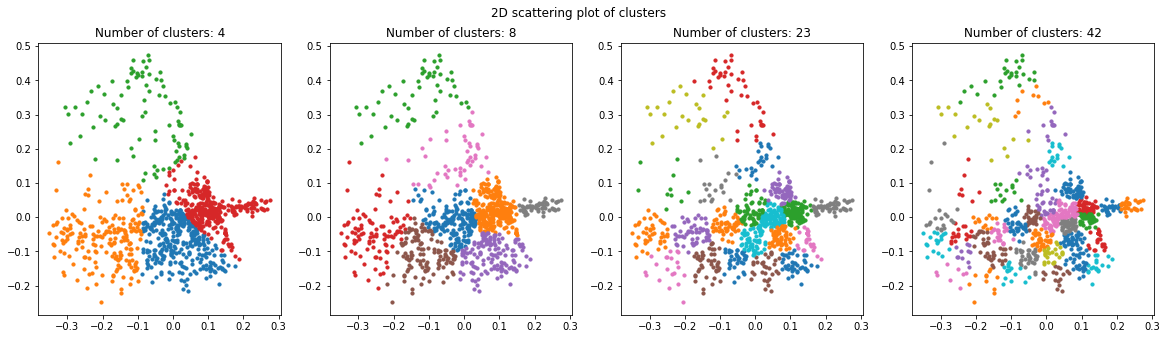

In [53]:
## p = 2
k_list = [4, 8, 23, 42]
plot_clusters(2, k_list, {})

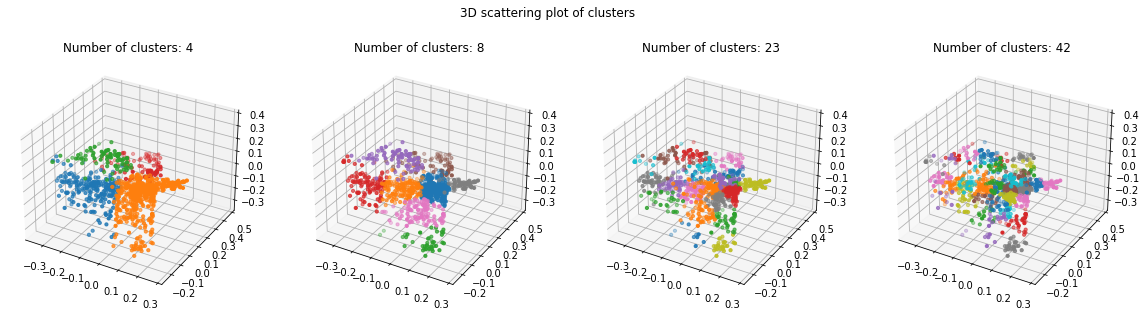

In [54]:
## p = 3
plot_clusters(3, k_list, {'projection': '3d'})

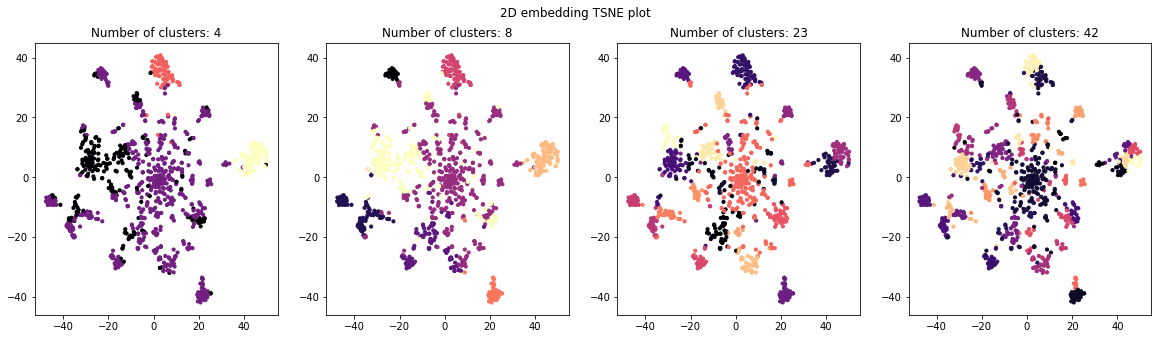

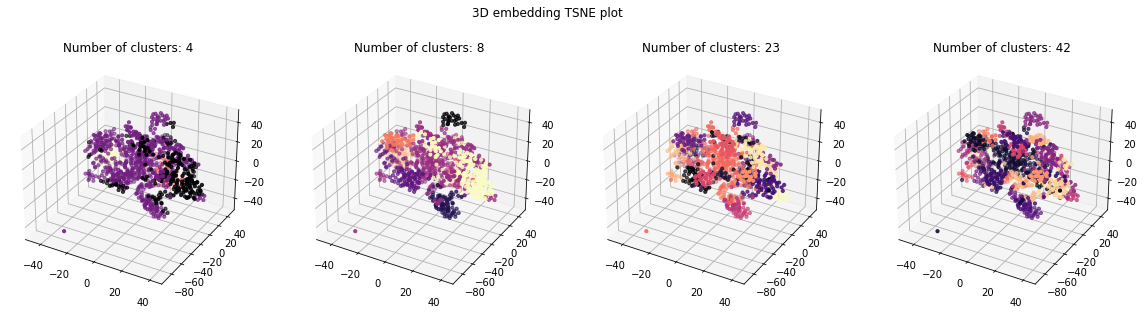

In [55]:
## choose p > 3, for example, p = p_opt, to compute CSE embeddings 
## First, cluster the computed p-dimentional embeddings and then project them onto 2-dimensional space 
## for visualization using PCA, LL, t-SNE or something else

warnings.filterwarnings('ignore')
plot_manifold(2, k_list, p_opt, {})
plot_manifold(3, k_list, p_opt, {'projection': '3d'})

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2]. You can reuse code from the previous coding exercises to align the cluster labels with the ground truth.
</p>

In [56]:
# Initialize community members affeliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))

The true number of clusters (departments) is:  42


<p style="background-color:#adebad;">
Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?
</p>

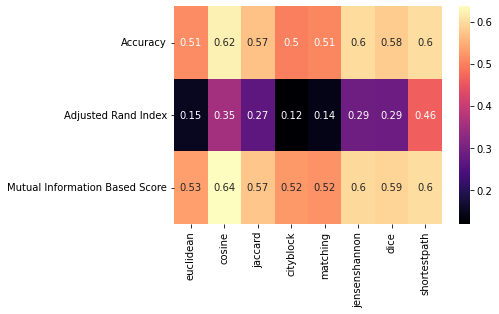

In [57]:
metrics = ["euclidean", "cosine", "jaccard", "cityblock", "matching", "jensenshannon", "dice", "shortestpath"]
popts = [18, 50, 50, 25, 22, 50, 50, 30]

accs = []
rands = []
infs = []

for i, metric in enumerate(metrics):
    CSE = ConstantShiftEmbedding(metric=metric)
    CSE.fit(DATA)
    Xp, none = CSE.get_embedded_vectors(popts[i])
    predictions = skl.cluster.KMeans(42).fit_predict(Xp)
    matched_predictions = matchinglabels(AFFILIATIONS, predictions)
    acc = skl.metrics.accuracy_score(AFFILIATIONS, matched_predictions)
    accs.append(acc)
    rand = skl.metrics.adjusted_rand_score(AFFILIATIONS, matched_predictions)
    rands.append(rand)
    inf = skl.metrics.normalized_mutual_info_score(AFFILIATIONS, matched_predictions)
    infs.append(inf)


metrics_dict = {
    'Accuracy': accs,
    'Adjusted Rand Index': rands,
    'Mutual Information Based Score': infs
}


df_metrics = pd.DataFrame(metrics_dict, index=metrics).transpose()
sns.heatmap(df_metrics, annot=True, cmap='magma')
plt.show()


From the above heatmap we can see that the choice of the metric heavily influence the performance of the CSE algorithm. The metrics that performed better are the Cosine metric and the shortest path metric.Please, write here your explanations, observation and thoughts about results of the experiments above.

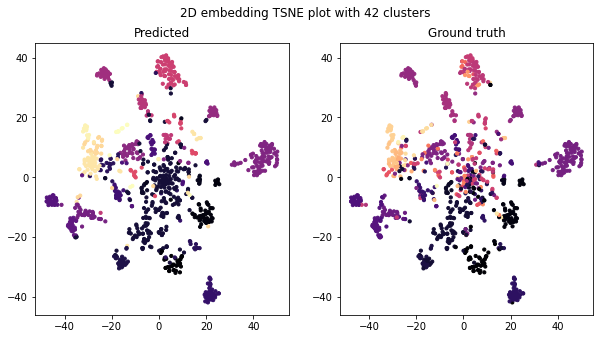

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

CSE = ConstantShiftEmbedding()
CSE.fit(DATA)

Xp, none = CSE.get_embedded_vectors(p_opt)
predictions = KMeans(n_clusters = 42, random_state= 42, n_init=50).fit_predict(Xp)
matched_predictions = matchinglabels(AFFILIATIONS, predictions)
tsne_embedding = TSNE(n_components=2, random_state=42).fit_transform(Xp)

ax[0].scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=matched_predictions, s=10 ,cmap='magma')
ax[0].set_title("Predicted")

ax[1].scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=AFFILIATIONS, s=10, cmap='magma')
ax[1].set_title("Ground truth")
fig.suptitle("2D embedding TSNE plot with 42 clusters")
plt.show()


I have evaluated my clustering result with the help of the function "matchinglabel" defined in section 4. Additionally I have tried different metrics to improve the algorithm but none of them could get  a very high accuracy (>64) or a high ARI score (>0.46). The capabilities of the CSE algorithm are thus beeing limited by the non optimal choice of the measure used in this task. 

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.